# 1. 数据预处理
## 1) 将数据转为矩阵形式存储

In [46]:
import pandas as pd
#读取原始数据
filename1 =r'ml-1m/users.dat'
filename2 = r'ml-1m/ratings.dat'
filename3 = r'ml-1m/movies.dat'
pd.options.display.max_rows = 10
uname = ['user_id','gender','age','occupation','zip']
users = pd.read_table(filename1, sep='::', header = None, names=uname)

rnames = ['user_id','movie_id','rating','timestamp']
ratings = pd.read_table(filename2, header =None, sep='::',names=rnames)

mnames = ['movie_id','title','genres']  # genres 表示影片的体裁是什么
movies = pd.read_table(filename3, header = None, sep='::', names = mnames, encoding="ISO-8859-1")

C:\Users\86157\AppData\Local\Temp/ipykernel_30420/2906986220.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users = pd.read_table(filename1, sep='::', header = None, names=uname)
C:\Users\86157\AppData\Local\Temp/ipykernel_30420/2906986220.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_table(filename2, header =None, sep='::',names=rnames)
C:\Users\86157\AppData\Local\Temp/ipykernel_30420/2906986220.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as

In [48]:
import numpy as np
rows=ratings["user_id"].max()
cols=ratings["movie_id"].max()
data=np.zeros((rows,cols))
for idx,raw_data in ratings.iterrows():
    r = raw_data['user_id']
    c = raw_data['movie_id']
    v = raw_data['rating']
    data[r-1][c-1]=v
np.save("data",data)

## 2) 训练集-验证集-测试集划分

In [88]:
import random
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
real_data=np.load("data.npy")
#将数据集划分为训练集、验证集、测试集
train_rate=0.8
val_rate=0.1
test_rate=0.1
rows,cols = real_data.shape
train_pos=np.zeros((rows,cols),dtype=bool)
val_pos=np.zeros((rows,cols),dtype=bool)
test_pos=np.zeros((rows,cols),dtype=bool)


for i in range(rows):
    # print(real_data[i]!=0)
    idx=np.where(real_data[i]!=0)[0]
    np.random.shuffle(idx)
    col_range=len(idx)
    
    # random.shuffle(col_range)
    val_bound=int(col_range*val_rate)
    test_bound=int(col_range*(val_rate+test_rate))
    
    val_idx = idx[:val_bound]
    test_idx = idx[val_bound:test_bound]
    train_idx  = idx[test_bound:]

    val_pos[i,val_idx]=1
    test_pos[i,test_idx]=1
    train_pos[i,train_idx]=1

In [89]:
train_data=np.zeros((rows,cols))
train_data[train_pos] = real_data[train_pos]
val_data=np.zeros((rows,cols))
val_data[val_pos]=real_data[val_pos]
test_data=np.zeros((rows,cols))
test_data[test_pos]=real_data[test_pos]

# 2. 训练

In [92]:
from tqdm import tqdm

P_best,Q_best=None,None

def get_rmse(error,sz):
    """计算rmse
    """
    rmse = np.sqrt((error**2).sum()/sz)
    return rmse

def get_mae(error,sz):
    """计算mae
    """
    mae=np.abs(error)/sz
    return mae

def istrain(train_data,val_data,iteration,eta,k,isprint=True):
    global P_best,Q_best
    train_loss=[]
    val_loss=[]

    missing_pos=train_data==0
    val_pos=val_data==0
    val_bestLoss=None

    rows,cols=train_data.shape
    #初始P矩阵和Q矩阵
    P=np.random.rand(rows,k)
    Q=np.random.rand(k,cols)
    train_sz=rows*cols-missing_pos.sum()
    val_sz=rows*cols-val_pos.sum()
    for t in tqdm(range(iteration)):
        #计算训练集误差
        r_hat=P@Q
        train_error=train_data-r_hat
        train_error[missing_pos]=0
        train_rmse=get_rmse(train_error,train_sz)


        #计算验证集误差
        val_error=val_data-r_hat
        val_error[val_pos]=0
        val_rmse=get_rmse(val_error,val_sz)
        if val_bestLoss is None or val_rmse<val_bestLoss:
            val_bestLoss=val_rmse
            P_best=P
            Q_best=Q

        #梯度下降，矩阵形式
        tP = P + eta*train_error@Q.T
        Q = Q + eta*P.T@train_error
        P = tP
        if isprint:
            print("step {},train_loss:{:.3f},val_loss:{:.3f}".format(t,train_rmse,val_rmse))

        train_loss.append(train_rmse)
        val_loss.append(val_rmse)
    return train_loss,val_loss
train_loss,val_loss = istrain(train_data,val_data,100,1e-4,10)


  1%|          | 1/100 [00:01<02:24,  1.46s/it]

step 0,train_loss:1.704,val_loss:1.703


  2%|▏         | 2/100 [00:02<02:22,  1.45s/it]

step 1,train_loss:1.487,val_loss:1.486


  3%|▎         | 3/100 [00:03<02:08,  1.33s/it]

step 2,train_loss:1.357,val_loss:1.356


  4%|▍         | 4/100 [00:05<02:03,  1.29s/it]

step 3,train_loss:1.274,val_loss:1.272


  5%|▌         | 5/100 [00:06<01:53,  1.19s/it]

step 4,train_loss:1.216,val_loss:1.215


  6%|▌         | 6/100 [00:07<01:45,  1.12s/it]

step 5,train_loss:1.174,val_loss:1.173


  7%|▋         | 7/100 [00:08<01:45,  1.14s/it]

step 6,train_loss:1.143,val_loss:1.142


  8%|▊         | 8/100 [00:09<01:56,  1.27s/it]

step 7,train_loss:1.117,val_loss:1.117


  9%|▉         | 9/100 [00:11<02:01,  1.33s/it]

step 8,train_loss:1.097,val_loss:1.097


 10%|█         | 10/100 [00:12<01:54,  1.27s/it]

step 9,train_loss:1.080,val_loss:1.081


 11%|█         | 11/100 [00:13<01:46,  1.20s/it]

step 10,train_loss:1.065,val_loss:1.067


 12%|█▏        | 12/100 [00:14<01:43,  1.18s/it]

step 11,train_loss:1.053,val_loss:1.055


 13%|█▎        | 13/100 [00:15<01:45,  1.21s/it]

step 12,train_loss:1.042,val_loss:1.044


 14%|█▍        | 14/100 [00:17<01:48,  1.26s/it]

step 13,train_loss:1.033,val_loss:1.035


 15%|█▌        | 15/100 [00:18<01:44,  1.23s/it]

step 14,train_loss:1.025,val_loss:1.027


 16%|█▌        | 16/100 [00:19<01:46,  1.26s/it]

step 15,train_loss:1.017,val_loss:1.020


 17%|█▋        | 17/100 [00:20<01:38,  1.18s/it]

step 16,train_loss:1.011,val_loss:1.014


 18%|█▊        | 18/100 [00:22<01:40,  1.22s/it]

step 17,train_loss:1.005,val_loss:1.009


 19%|█▉        | 19/100 [00:23<01:43,  1.28s/it]

step 18,train_loss:0.999,val_loss:1.004


 20%|██        | 20/100 [00:24<01:42,  1.28s/it]

step 19,train_loss:0.994,val_loss:0.999


 21%|██        | 21/100 [00:25<01:36,  1.22s/it]

step 20,train_loss:0.990,val_loss:0.995


 22%|██▏       | 22/100 [00:27<01:36,  1.23s/it]

step 21,train_loss:0.986,val_loss:0.991


 23%|██▎       | 23/100 [00:28<01:34,  1.23s/it]

step 22,train_loss:0.982,val_loss:0.988


 24%|██▍       | 24/100 [00:29<01:27,  1.16s/it]

step 23,train_loss:0.979,val_loss:0.984


 25%|██▌       | 25/100 [00:30<01:20,  1.07s/it]

step 24,train_loss:0.975,val_loss:0.981


 26%|██▌       | 26/100 [00:31<01:17,  1.04s/it]

step 25,train_loss:0.972,val_loss:0.979


 27%|██▋       | 27/100 [00:32<01:23,  1.15s/it]

step 26,train_loss:0.970,val_loss:0.976


 28%|██▊       | 28/100 [00:33<01:27,  1.22s/it]

step 27,train_loss:0.967,val_loss:0.974


 29%|██▉       | 29/100 [00:34<01:22,  1.16s/it]

step 28,train_loss:0.965,val_loss:0.972


 30%|███       | 30/100 [00:36<01:22,  1.18s/it]

step 29,train_loss:0.962,val_loss:0.970


 31%|███       | 31/100 [00:37<01:17,  1.12s/it]

step 30,train_loss:0.960,val_loss:0.968


 32%|███▏      | 32/100 [00:38<01:18,  1.16s/it]

step 31,train_loss:0.958,val_loss:0.966


 33%|███▎      | 33/100 [00:39<01:14,  1.12s/it]

step 32,train_loss:0.956,val_loss:0.964


 34%|███▍      | 34/100 [00:40<01:16,  1.15s/it]

step 33,train_loss:0.954,val_loss:0.962


 35%|███▌      | 35/100 [00:41<01:16,  1.18s/it]

step 34,train_loss:0.953,val_loss:0.961


 36%|███▌      | 36/100 [00:42<01:14,  1.16s/it]

step 35,train_loss:0.951,val_loss:0.960


 37%|███▋      | 37/100 [00:44<01:14,  1.19s/it]

step 36,train_loss:0.949,val_loss:0.958


 38%|███▊      | 38/100 [00:45<01:11,  1.15s/it]

step 37,train_loss:0.948,val_loss:0.957


 39%|███▉      | 39/100 [00:46<01:10,  1.15s/it]

step 38,train_loss:0.947,val_loss:0.956


 40%|████      | 40/100 [00:47<01:07,  1.13s/it]

step 39,train_loss:0.945,val_loss:0.955


 41%|████      | 41/100 [00:48<01:08,  1.17s/it]

step 40,train_loss:0.944,val_loss:0.954


 42%|████▏     | 42/100 [00:49<01:03,  1.09s/it]

step 41,train_loss:0.943,val_loss:0.952


 43%|████▎     | 43/100 [00:50<01:00,  1.06s/it]

step 42,train_loss:0.942,val_loss:0.951


 44%|████▍     | 44/100 [00:51<00:58,  1.04s/it]

step 43,train_loss:0.940,val_loss:0.951


 45%|████▌     | 45/100 [00:52<00:54,  1.01it/s]

step 44,train_loss:0.939,val_loss:0.950


 46%|████▌     | 46/100 [00:53<00:54,  1.01s/it]

step 45,train_loss:0.938,val_loss:0.949


 47%|████▋     | 47/100 [00:54<00:52,  1.01it/s]

step 46,train_loss:0.937,val_loss:0.948


 48%|████▊     | 48/100 [00:55<00:53,  1.02s/it]

step 47,train_loss:0.936,val_loss:0.947


 49%|████▉     | 49/100 [00:56<00:50,  1.00it/s]

step 48,train_loss:0.935,val_loss:0.946


 50%|█████     | 50/100 [00:57<00:50,  1.01s/it]

step 49,train_loss:0.935,val_loss:0.946


 51%|█████     | 51/100 [00:58<00:48,  1.01it/s]

step 50,train_loss:0.934,val_loss:0.945


 52%|█████▏    | 52/100 [00:59<00:47,  1.02it/s]

step 51,train_loss:0.933,val_loss:0.944


 53%|█████▎    | 53/100 [01:00<00:46,  1.00it/s]

step 52,train_loss:0.932,val_loss:0.944


 54%|█████▍    | 54/100 [01:01<00:43,  1.06it/s]

step 53,train_loss:0.931,val_loss:0.943


 55%|█████▌    | 55/100 [01:02<00:40,  1.11it/s]

step 54,train_loss:0.931,val_loss:0.943


 56%|█████▌    | 56/100 [01:03<00:39,  1.13it/s]

step 55,train_loss:0.930,val_loss:0.942


 57%|█████▋    | 57/100 [01:03<00:37,  1.14it/s]

step 56,train_loss:0.929,val_loss:0.941


 58%|█████▊    | 58/100 [01:04<00:38,  1.10it/s]

step 57,train_loss:0.929,val_loss:0.941


 59%|█████▉    | 59/100 [01:05<00:37,  1.09it/s]

step 58,train_loss:0.928,val_loss:0.940


 60%|██████    | 60/100 [01:06<00:35,  1.11it/s]

step 59,train_loss:0.927,val_loss:0.940


 61%|██████    | 61/100 [01:07<00:37,  1.03it/s]

step 60,train_loss:0.927,val_loss:0.939


 62%|██████▏   | 62/100 [01:08<00:36,  1.05it/s]

step 61,train_loss:0.926,val_loss:0.939


 63%|██████▎   | 63/100 [01:09<00:33,  1.12it/s]

step 62,train_loss:0.926,val_loss:0.938


 64%|██████▍   | 64/100 [01:10<00:30,  1.17it/s]

step 63,train_loss:0.925,val_loss:0.938


 65%|██████▌   | 65/100 [01:11<00:31,  1.13it/s]

step 64,train_loss:0.924,val_loss:0.938


 66%|██████▌   | 66/100 [01:12<00:31,  1.08it/s]

step 65,train_loss:0.924,val_loss:0.937


 67%|██████▋   | 67/100 [01:13<00:29,  1.10it/s]

step 66,train_loss:0.923,val_loss:0.937


 68%|██████▊   | 68/100 [01:14<00:28,  1.11it/s]

step 67,train_loss:0.923,val_loss:0.936


 69%|██████▉   | 69/100 [01:14<00:27,  1.11it/s]

step 68,train_loss:0.922,val_loss:0.936


 70%|███████   | 70/100 [01:15<00:26,  1.13it/s]

step 69,train_loss:0.922,val_loss:0.936


 71%|███████   | 71/100 [01:16<00:25,  1.14it/s]

step 70,train_loss:0.922,val_loss:0.935


 72%|███████▏  | 72/100 [01:17<00:24,  1.15it/s]

step 71,train_loss:0.921,val_loss:0.935


 73%|███████▎  | 73/100 [01:18<00:22,  1.18it/s]

step 72,train_loss:0.921,val_loss:0.935


 74%|███████▍  | 74/100 [01:19<00:22,  1.18it/s]

step 73,train_loss:0.920,val_loss:0.934


 75%|███████▌  | 75/100 [01:19<00:21,  1.17it/s]

step 74,train_loss:0.920,val_loss:0.934


 76%|███████▌  | 76/100 [01:20<00:20,  1.17it/s]

step 75,train_loss:0.919,val_loss:0.934


 77%|███████▋  | 77/100 [01:21<00:19,  1.16it/s]

step 76,train_loss:0.919,val_loss:0.934


 78%|███████▊  | 78/100 [01:22<00:18,  1.16it/s]

step 77,train_loss:0.919,val_loss:0.933


 79%|███████▉  | 79/100 [01:23<00:17,  1.19it/s]

step 78,train_loss:0.918,val_loss:0.933


 80%|████████  | 80/100 [01:24<00:16,  1.18it/s]

step 79,train_loss:0.918,val_loss:0.933


 81%|████████  | 81/100 [01:25<00:17,  1.09it/s]

step 80,train_loss:0.918,val_loss:0.932


 82%|████████▏ | 82/100 [01:26<00:16,  1.07it/s]

step 81,train_loss:0.917,val_loss:0.932


 83%|████████▎ | 83/100 [01:27<00:15,  1.07it/s]

step 82,train_loss:0.917,val_loss:0.932


 84%|████████▍ | 84/100 [01:28<00:14,  1.09it/s]

step 83,train_loss:0.916,val_loss:0.932


 85%|████████▌ | 85/100 [01:28<00:13,  1.12it/s]

step 84,train_loss:0.916,val_loss:0.931


 86%|████████▌ | 86/100 [01:29<00:12,  1.15it/s]

step 85,train_loss:0.916,val_loss:0.931


 87%|████████▋ | 87/100 [01:30<00:11,  1.18it/s]

step 86,train_loss:0.916,val_loss:0.931


 88%|████████▊ | 88/100 [01:31<00:09,  1.20it/s]

step 87,train_loss:0.915,val_loss:0.931


 89%|████████▉ | 89/100 [01:32<00:09,  1.19it/s]

step 88,train_loss:0.915,val_loss:0.931


 90%|█████████ | 90/100 [01:33<00:08,  1.14it/s]

step 89,train_loss:0.915,val_loss:0.930


 91%|█████████ | 91/100 [01:34<00:08,  1.08it/s]

step 90,train_loss:0.914,val_loss:0.930


 92%|█████████▏| 92/100 [01:35<00:08,  1.01s/it]

step 91,train_loss:0.914,val_loss:0.930


 93%|█████████▎| 93/100 [01:36<00:06,  1.01it/s]

step 92,train_loss:0.914,val_loss:0.930


 94%|█████████▍| 94/100 [01:37<00:05,  1.02it/s]

step 93,train_loss:0.913,val_loss:0.930


 95%|█████████▌| 95/100 [01:38<00:05,  1.00s/it]

step 94,train_loss:0.913,val_loss:0.929


 96%|█████████▌| 96/100 [01:39<00:04,  1.10s/it]

step 95,train_loss:0.913,val_loss:0.929


 97%|█████████▋| 97/100 [01:40<00:03,  1.05s/it]

step 96,train_loss:0.913,val_loss:0.929


 98%|█████████▊| 98/100 [01:41<00:02,  1.13s/it]

step 97,train_loss:0.912,val_loss:0.929


 99%|█████████▉| 99/100 [01:42<00:01,  1.07s/it]

step 98,train_loss:0.912,val_loss:0.929


100%|██████████| 100/100 [01:43<00:00,  1.04s/it]

step 99,train_loss:0.912,val_loss:0.929


## 选取不同的参数组合

100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


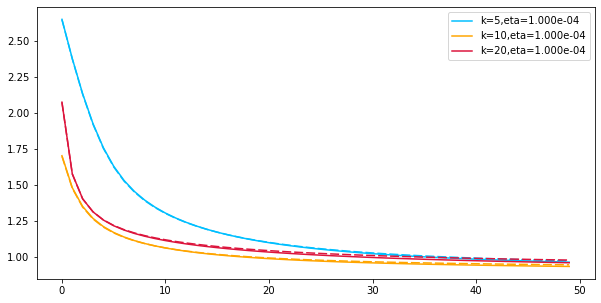

In [103]:
from matplotlib import pyplot as plt
def plot_loss(loss,k,eta,color,flag=False):
    """绘制损失函数下降曲线
    """
    label="k={},eta={:.3e}".format(k,eta)
    if flag:
        plt.plot(loss,dashes=[6, 2],color=color)
    else:
        plt.plot(loss,label=label,color=color)

ks=[5,10,20]
eta=1e-4
iteration=50
colors=["deepskyblue","orange","crimson"]
fig=plt.figure(figsize=(10,5))
for i,k in enumerate(ks):
    c=colors[i]
    train_loss,val_loss=istrain(train_data,val_data,iteration,eta,k,False)
    plot_loss(train_loss,k,eta,c)
    plot_loss(val_loss,k,eta,c,True)
plt.legend()
plt.show()

100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


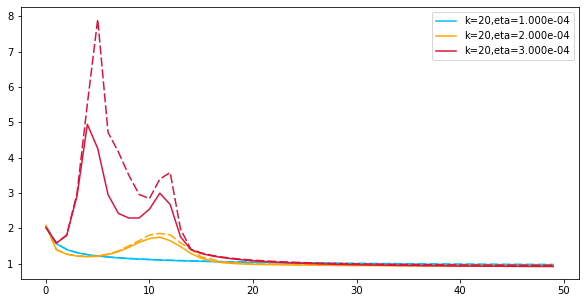

In [104]:
ks=10
etas=[1e-4,2*1e-4,3*1e-4]
iteration=50
colors=["deepskyblue","orange","crimson"]
fig=plt.figure(figsize=(10,5))
for i,eta in enumerate(etas):
    c=colors[i]
    train_loss,val_loss=istrain(train_data,val_data,iteration,eta,k,False)
    plot_loss(train_loss,k,eta,c)
    plot_loss(val_loss,k,eta,c,True)
plt.legend()
plt.show()

In [114]:
istrain(train_data,val_data,100,2*1e-4,10,False)

#计算测试集误差
r_hat = P_best@Q_best
test_pos = test_data==0
test_error = test_data-r_hat
test_error[test_pos]=0
test_sz=rows*cols-test_pos.sum()
test_rmse=get_rmse(test_error,test_sz)
print(test_rmse)

100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


0.9250920265692901


# 3. 计算precission@k并与其他推荐算法比较

In [115]:
# 计算测试集Precission@k
r_hat = P_best@Q_best
test_pos = test_data==0

test_data[test_pos]=0
r_hat[test_pos]=0

pre_data = np.ceil(r_hat)
real_data = test_data
#从大到小
pre_idx = np.argsort(-pre_data)
real_idx = np.argsort(-real_data)
pk=[]
for i in range(rows):
    cnt=0
    #只统计不为0的部分
    cols_range=(real_data[i]!=0).sum()
    for item_idx in range(cols_range):
        item_idx=pre_idx[i][item_idx]
        pre_rating = pre_data[i][item_idx]
        real_rating = real_data[i][item_idx]
        if pre_rating==real_rating:
            cnt+=1
    pk.append(cnt/cols_range)

pk=np.array(pk)
print(pk.mean())

0.4035736434706291


In [94]:
##与其他推荐算法比较
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

data = Dataset.load_builtin('ml-100k')

# 先比较库中的SVD与自己实现的SVD效果
algo = SVD()

# 5折交叉验证
print(cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True))

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9355  0.9334  0.9402  0.9398  0.9316  0.9361  0.0034  
MAE (testset)     0.7366  0.7373  0.7394  0.7407  0.7338  0.7376  0.0024  
Fit time          6.16    7.58    7.80    7.47    7.95    7.39    0.64    
Test time         0.37    0.40    0.44    0.39    0.37    0.40    0.03    
{'test_rmse': array([0.93546929, 0.93337021, 0.94023685, 0.93982291, 0.93162052]), 'test_mae': array([0.73658683, 0.73731736, 0.73937111, 0.74068715, 0.73380995]), 'fit_time': (6.160890579223633, 7.584797143936157, 7.802205324172974, 7.469327688217163, 7.9492340087890625), 'test_time': (0.37104249000549316, 0.3979959487915039, 0.4430105686187744, 0.39099740982055664, 0.3740067481994629)}


In [98]:
#使用KNNBsaeline算法
from surprise import KNNBaseline
algo = KNNBaseline()
print(cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True))


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9273  0.9256  0.9283  0.9411  0.9254  0.9296  0.0059  
MAE (testset)     0.7270  0.7303  0.7316  0.7414  0.7311  0.7323  0.0048  
Fit time          0.88    0.89    0.96    1.05    1.00    0.96    0.07    
Test time         9.08    11.45   12.77   12.08   10.85   11.25   1.26    
{'test_rmse': array([0.92731189, 0.92562962